## Домашнее задание по теме «Ансамблирование»

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# profile = pandas_profiling.ProfileReport(df, title='House prices report', html={'style':{'full_width':True}})
# profile.to_file(output_file="house_prices_report.html")

In [4]:
# удаляем столбцы где пропущенные или нулевые значения от 50% и выше.
data = df.drop(['2ndFlrSF', '3SsnPorch', 'Alley', 'BsmtFinSF2', 'EnclosedPorch', 'Fence', 'LowQualFinSF', 'MasVnrArea',
                  'MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC', 'ScreenPorch', 'WoodDeckSF', 'MasVnrType', 'Id'],
                     axis=1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,548,TA,TA,Y,61,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,460,TA,TA,Y,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,608,TA,TA,Y,42,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,642,TA,TA,Y,35,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,836,TA,TA,Y,84,12,2008,WD,Normal,250000


In [5]:
# категориальные и числовые признаки
cat_col = [i for i in data.columns if data[i].dtype.name == 'object']
num_col   = [i for i in data.columns if data[i].dtype.name != 'object']

for i in cat_col:
    data[i].fillna('None', inplace=True)
    
for j in num_col:
    data[j].fillna(0, inplace=True)
    
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,548,TA,TA,Y,61,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,460,TA,TA,Y,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,608,TA,TA,Y,42,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,642,TA,TA,Y,35,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,836,TA,TA,Y,84,12,2008,WD,Normal,250000


In [6]:
# категориальные признаки приведем к числовым
for i in cat_col:
    try:
        cat_encod = LabelEncoder()
        data[i] = cat_encod.fit_transform(data[i])
    except:
        continue

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,548,5,5,2,61,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,0,2,0,...,460,5,5,2,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,0,4,0,...,608,5,5,2,42,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,0,...,642,5,5,2,35,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,0,2,0,...,836,5,5,2,84,12,2008,8,4,250000


In [7]:
cat_last = [i for i in data.columns if data[i].dtype.name == 'object']
data.drop(cat_last, axis=1, inplace=True)

In [8]:
data.fillna(0, inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,548,5,5,2,61,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,0,2,0,...,460,5,5,2,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,0,4,0,...,608,5,5,2,42,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,0,...,642,5,5,2,35,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,0,2,0,...,836,5,5,2,84,12,2008,8,4,250000


In [9]:
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random Forest

In [11]:
clf = RandomForestRegressor(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [12]:
# оцениваем качество модели
scores = cross_val_score(clf, X_train, y_train, cv=10)
y_pred = clf.predict(X_test)
print('Score: {:.2f}'.format(scores.mean()))
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

Score: 0.84
R2 score: 0.85


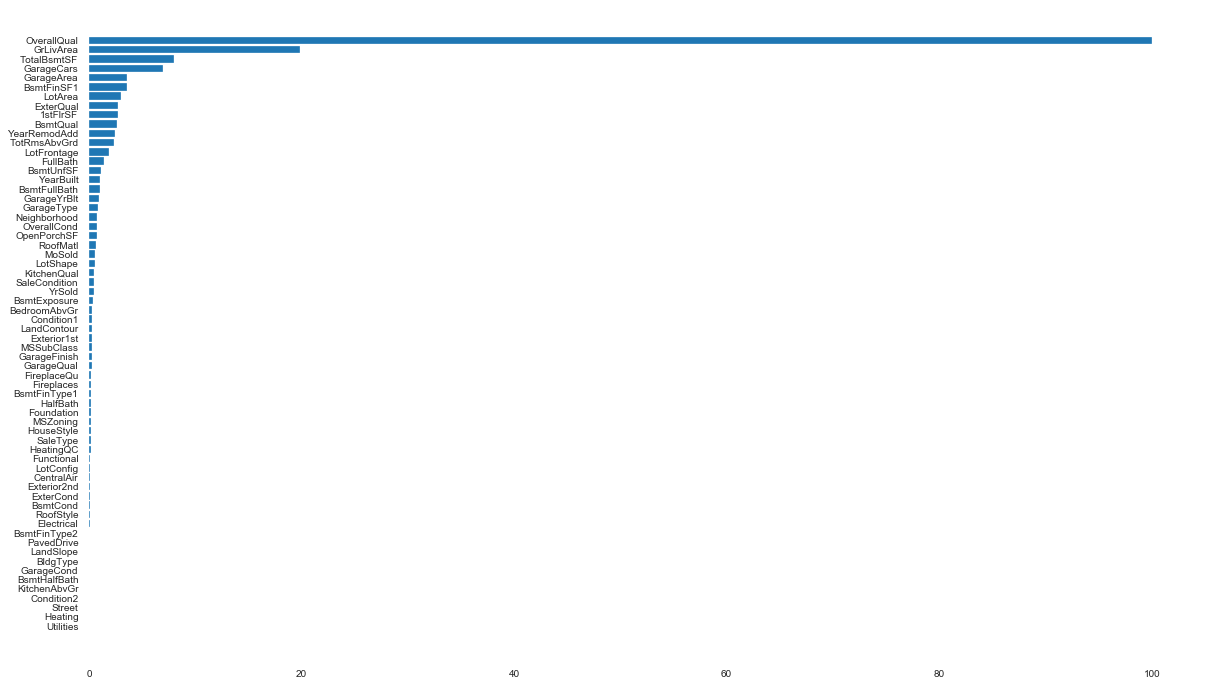

In [13]:
# важность параметров модели
importance = clf.feature_importances_
importance = 100.0 * (importance / importance.max())
sorted_index = np.argsort(importance)
p = np.arange(sorted_index.shape[0]) + .5
plt.figure(figsize=(20, 12))
plt.barh(p, importance[sorted_index])
plt.yticks(p, data.columns[sorted_index])
plt.show()

Text(0.5, 0, 'TotalBsmtSF')

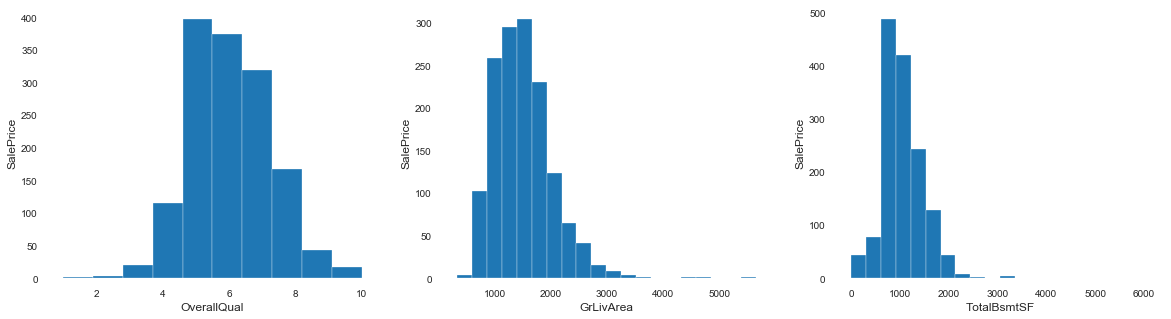

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(data['OverallQual'], bins=10)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('OverallQual', fontsize=12)
plt.subplot(132)
plt.hist(data['GrLivArea'], bins=20)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('GrLivArea', fontsize=12)
plt.subplot(133)
plt.hist(data['TotalBsmtSF'], bins=20)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('TotalBsmtSF', fontsize=12)

In [15]:
estimators = [
    ('linear', LinearRegression()),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]

In [16]:
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))

In [17]:
stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('linear',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('Lasso',
                               LassoCV(alphas=None, copy_X=True, cv=None,
                                       eps=0.001, fit_intercept=True,
                                       max_iter=1000, n_alphas=100, n_jobs=None,
                                       normalize=False, positive=False,
                                       precompute='auto', random_state=None,
                                       selection='cyclic', tol=0.0001,
                                       verbose=Fa...
                  final_estimator=RandomForestRegressor(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        criterion='mse',
                 

In [18]:
y_pred_stacking_regressor = stacking_regressor.predict(X_test)
score_ensemble = cross_val_score(stacking_regressor, X_train, y_train, cv=10)
print('Score ensemble: {:.2f}'.format(score_ensemble.mean()))
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred_stacking_regressor)))

Score ensemble: 0.86
R2 score: 0.90
